In [342]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import queue
import operator
from functools import reduce

## My Incremental Delaunay

In [2]:
def sub_vec(a, b):
    return (a[0] - b[0], a[1] - b[1])

In [3]:
def prod_vec(a, b):
    return a[0] * b[1] - a[1] * b[0]

In [4]:
def convex(vertex1, vertex2, vertex3):
    if prod_vec(sub_vec(vertex1, vertex2), sub_vec(vertex2, vertex3)) > 0:
        return True
    return False

In [297]:
def point_in_triangle(point, vertex1, vertex2, vertex3):
        sideAB = convex(point, vertex1, vertex2)
        sideBC = convex(point, vertex2, vertex3)
        sideCA = convex(point, vertex3, vertex1)
        return sideAB == sideBC == sideCA and sideAB

In [300]:
import math

def distance(x,y):
    return math.sqrt((x[0] - y[0]) ** 2 + (x[1] - y[1]) ** 2)

def is_between(p,x,y):
    epsilon = 0.0000001
    return abs((distance(p,x) + distance(p,y)) - distance(x,y)) < epsilon

def point_in_edge(point,vertex1, vertex2, vertex3):
    if is_between(point, vertex1, vertex2): return (vertex1, vertex2, vertex3)
    if is_between(point, vertex2, vertex3): return (vertex2, vertex3, vertex1)
    if is_between(point, vertex3, vertex1): return (vertex3, vertex1, vertex2)
    
    return False

In [301]:
def contains_all_points(p1, p2, p3, polygon):
    sort = [p1,p2,p3].copy()
    sort = sort_clockwise([p1,p2,p3])
    
    p1 = tuple(sort[0])
    p2 = tuple(sort[1])
    p3 = tuple(sort[2])
    
    for pn in polygon:
        if pn in (p1, p2, p3):
            continue
        elif not(point_in_triangle(pn, p1, p2, p3)):
            return False
    return True

In [ ]:
def createFirstTriangle(points):
    global p2_a
    global p3_a
    p1_x = 1000
    p1_y = 1000
    
    min_x = 1000
    min_y = 1000
    max_x = -1000
    max_y = -1000
    
    for point in points:
        if point[0] == p1_x and point[1] < p1_y:
            p1_x = point[0]
            p1_y = point[1]
        if point[0] < p1_x:
            p1_x = point[0]
            p1_y = point[1]
            
        if point[1] > max_y: max_y = point[1]
        if point[1] < min_y: min_y = point[1]
        if point[0] > max_x: max_x = point[0]
        if point[0] < min_x: min_x = point[0]
        
    p1 = [p1_x, p1_y]
    
    real_point = p1
    
    #p2 = [p1_x - 2, p1_y + 20]
    #p3 = [p1_x + 10, p1_y - 2]
    
    p2 = p2_a
    p3 = p3_a
    
    
    a1=np.empty((len(points),), dtype=object)
    a1[:]=[tuple(i) for i in points]
    
    checker = 0
    flag = 0
    
    while not(contains_all_points(p1,p2,p3,a1)):
        p2[0] -= 0.001
        p2[1] += 0.05
        p3[0] += 0.05
        p3[1] -= 0.001
        print("ERROR")
        
    
    return np.array([p1, p2, p3]), np.array([p2, p3]), real_point

In [303]:
def sort_clockwise(data):
    center = tuple(map(operator.truediv, reduce(lambda x, y: map(operator.add, x, y), data), [len(data)] * 2))
    data = sorted(data, key=lambda data: (-135 - math.degrees(math.atan2(*tuple(map(operator.sub, data, center))[::-1]))) % 360)
    data.reverse()
    return data

In [304]:
def getAngle(a, b, c):
    ang = math.degrees(math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
    return ang + 360 if ang < 0 else ang

from collections import Counter

def number_of_duplicates(list_a, list_b):
    result = 0
    for elem in list_a:
        for elem2 in list_b:
            if elem == elem2:
                result += 1
                break
        
    return result

def haveIntersection(t1,t2):
    return number_of_duplicates(t1,t2) == 2

def getAnglesSum(t1, t2, points):
    angle1 = 0
    angle2 = 0
    for i in range(3):
        if t1[i] not in t2:
            tmp = [t1[(i - 1) % 3], t1[(i + 1) % 3]]
            tmp = sort_clockwise(tmp)
            tmp.insert(1,t1[i])
            
            angle1 = getAngle(tmp[0], tmp[1], tmp[2])
            
            if angle1 > 180:
                tmp.reverse()
                angle1 = getAngle(tmp[0], tmp[1], tmp[2])
            
            break
    
    for i in range(3):
        if t2[i] not in t1:
            tmp = [t2[(i - 1) % 3], t2[(i + 1) % 3]]
            tmp = sort_clockwise(tmp)
            tmp.insert(1,t2[i])
            angle2 = getAngle(tmp[0], tmp[1], tmp[2])
            
            if angle2 > 180:
                tmp.reverse()
                angle2 = getAngle(tmp[0], tmp[1], tmp[2])
                
            break
    
    return angle1 + angle2

def changeDiagonal(t1,t2):
    tmp1 = 0
    tmp2 = 0
    for i in range(3):
        if t1[i] not in t2:
            tmp1 = i
            break
    for i in range(3):
        if t2[i] not in t1:
            tmp2 = i
            break
    
    result1 = [t1[tmp1], t2[tmp2], t2[(tmp2 + 1) % 3]]
    result2 = [t1[tmp1], t2[tmp2], t2[(tmp2 + 2) % 3]]
    
    return result1, result2

def applyFlip(triangles, points):
    #print("POINTS: ",triangles)
    end = False
    while not(end):
        end = True
        for t1, triangle1 in enumerate(triangles):
            for t2, triangle2 in enumerate(triangles):
                if t1 == t2: continue
                if haveIntersection(triangle1, triangle2):
                    angle_sum = getAnglesSum(triangle1, triangle2, points)

                    if angle_sum > 180:
                        end = False
                        
                        #print("HIT ", triangle1, triangle2)
                        tmp1, tmp2 = changeDiagonal(triangle1, triangle2)
                        triangles[t1] = tmp1
                        triangles[t2] = tmp2
    
    return triangles

In [329]:
def DelaunayIncremental(points_input):
    points = points_input.copy()
    points = points.tolist()
        
    points_queue = queue.Queue()
    
    list(map(points_queue.put, points))
        
    super_triangle, super_nodes, real_point = createFirstTriangle(points)
    
    super_triangle = super_triangle.tolist()
    super_triangle = sort_clockwise(super_triangle)
    
    #print("REAL: ", real_point)
    
    triangles = []
    triangles.append(super_triangle)
        
    while not(points_queue.empty()):
        point = points_queue.get()
        if point in super_triangle: continue
        #print()
        #print("POINT: ", point)
        
        for actual_triangle in triangles:
            removing_triangle = actual_triangle
            actual_triangle = sort_clockwise(actual_triangle)

            vertex1 = actual_triangle[0]
            vertex2 = actual_triangle[1]
            vertex3 = actual_triangle[2]
            
            if point == vertex1 or point == vertex2 or point == vertex3: continue
        
            if point_in_triangle(point, vertex1, vertex2, vertex3):
                #print("IN ", vertex1, vertex2, vertex3)
                try:
                    triangles.remove(removing_triangle)
                except:
                    print()
                
                triangles.insert(0, sort_clockwise([point, vertex1, vertex2]))
                triangles = applyFlip(triangles, points)
                triangles.insert(0, sort_clockwise([point, vertex2, vertex3]))
                triangles = applyFlip(triangles, points)
                triangles.insert(0, sort_clockwise([point, vertex3, vertex1]))
                triangles = applyFlip(triangles, points)
                
                continue
                
            detect_edge = point_in_edge(point, vertex1, vertex2, vertex3)
            if detect_edge:
                try:
                    triangles.remove(removing_triangle)
                except:
                    print()
                
                vertex1_prim = detect_edge[0]
                vertex2_prim = detect_edge[1]
                vertex3_prim = detect_edge[2]
                
                triangles.insert(0, sort_clockwise([point, vertex1_prim, vertex3_prim]))
                triangles = applyFlip(triangles, points)

                triangles.insert(0, sort_clockwise([point, vertex2_prim, vertex3_prim]))
                triangles = applyFlip(triangles, points)
            
    edges = []
    
    for elem in triangles:
        vertex1, vertex2, vertex3 = elem
        if not(vertex1 in super_nodes or
               vertex2 in super_nodes or
               vertex3 in super_nodes):
            edges.append([points.index(vertex1), points.index(vertex2), points.index(vertex3)])
        
        else:
            
            #edges.append([points.index(point), points.index(real_point), points.index(real_point)])

            if not(vertex1 in super_nodes or
                   vertex2 in super_nodes): 
                edges.append([points.index(vertex1), points.index(vertex1), points.index(vertex2)])
            if not(vertex2 in super_nodes or
                   vertex3 in super_nodes): 
                edges.append([points.index(vertex2), points.index(vertex2), points.index(vertex3)])
            if not(vertex3 in super_nodes or
                   vertex1 in super_nodes): 
                edges.append([points.index(vertex3), points.index(vertex3), points.index(vertex1)])
    
    return edges

In [349]:
points = np.random.rand(50,2)
#points = np.array([[0,1], [-1,0], [1,0.1], [0,0.5]])
points = np.round(points, decimals=8)
points = np.array(sort_clockwise(points.tolist()))

In [350]:
points

array([[0.17931212, 0.07181456],
       [0.24047409, 0.0189499 ],
       [0.30034339, 0.00798305],
       [0.43714852, 0.29272181],
       [0.49972654, 0.04308288],
       [0.51881202, 0.17798641],
       [0.52446201, 0.20437876],
       [0.53131173, 0.13779511],
       [0.67123241, 0.16886306],
       [0.69818982, 0.1623593 ],
       [0.91745296, 0.00528134],
       [0.7687477 , 0.19318331],
       [0.6682553 , 0.37757631],
       [0.89810252, 0.34054319],
       [0.90595462, 0.33940095],
       [0.85052652, 0.41193791],
       [0.71792618, 0.47546678],
       [0.80271883, 0.4817549 ],
       [0.80668841, 0.554469  ],
       [0.73249791, 0.55005836],
       [0.98621139, 0.622062  ],
       [0.99092153, 0.68124743],
       [0.89861809, 0.68917744],
       [0.85697369, 0.67922386],
       [0.82241394, 0.86405516],
       [0.68119429, 0.72585527],
       [0.79642075, 0.88794394],
       [0.70197552, 0.91985135],
       [0.63455101, 0.99516562],
       [0.62126239, 0.96843213],
       [0.

In [351]:
p2_a = [3, 20000]
p3_a = [3, -20000]

edges = DelaunayIncremental(points)
#edges

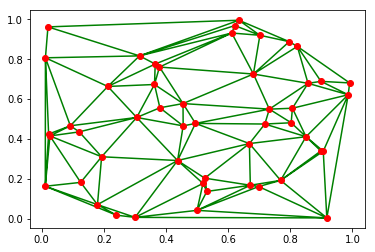

In [352]:
points2 = np.array(points)

#plt.figure(figsize=(15,20))
plt.plot(points2[:,0], points2[:,1], 'o', color="red")
plt.triplot(points2[:,0], points2[:,1], edges.copy(), color = 'green')
plt.show()